In [61]:
import os
import sys

# os.chdir('../')
sys.path.append(os.getcwd())

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from sklearn.decomposition import PCA
from scipy.stats import fisher_exact, chi2_contingency
from sklearn.manifold import TSNE, MDS
from tqdm import tqdm
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC
from sklearn.metrics import f1_score, precision_score, recall_score, roc_curve
from multipy.fwer import sidak, hochberg
from xgboost import XGBClassifier
import random

from utils.viz_utils import plot_usage_matrix_pca, plot_boxplots_for_usage_matrix, _plot_feature_importance, plot_v_usage_hist, \
                                plot_cluster_map, significant_clones_distribution, plot_results_for_hla_class, plot_generated_to_real_distribution, \
                            plot_olga_cleanup_data, plot_clusters_of_clonotypes, plot_cooccurence_heatmap_with_epitopes_labeling, plot_waterfall_by_column, \
                            plot_feature_importances, plot_volcano, plot_clonotype_clustering_with_epitope_labeling
from utils.ml_utils import get_parameters, prepare_data, evaluate_models, split_data_by_batch, cross_validation_between_batches, make_hla_predictor
from utils.data_utils import prepare_run_column
from utils.stats_utils import evaluate_anova_testing, evaluate_mannwhitneyu_testing, get_top_changed_clonotypes
from utils.clustering_utils import seqs2hamming, check_significant_epitopes_for_cluster, get_most_frequent_cluster_by_vdjdb_occurence
from utils.weblogo_utils import create_web_logo
from source.alpha_beta_paired_clones_search import make_metaclone_cm


import warnings
warnings.filterwarnings('ignore')


import importlib
imported_module = importlib.import_module("utils.viz_utils")
importlib.reload(imported_module)

/home/evlasova/tcr-covid-classifier


<module 'utils.viz_utils' from '/home/evlasova/tcr-covid-classifier/utils/viz_utils.py'>

# Reading UMs

In [4]:
norm_um_joint = pd.read_csv('data/normalized_usage_matrix_joint.csv').drop(columns=['Unnamed: 0']).fillna(0)
stand_um_joint = pd.read_csv('data/standardized_usage_matrix_joint.csv').drop(columns=['Unnamed: 0']).fillna(0)

In [5]:
norm_um_joint['project'] = norm_um_joint['project'].apply(lambda x: x.replace('_DNA', '').split('_')[-1])

In [6]:
stand_um_joint['project'] = stand_um_joint['project'].apply(lambda x: x.replace('_DNA', '').split('_')[-1])

In [7]:
stand_um_joint

,run,project,covid,TRBV7-2,TRBV7-5,TRBV16,TRBV11-2,TRBV28,TRBV5-4,TRBV7-3,...,TRBV27,TRBV11-1,TRBV30,TRBV6-2,TRBV12-3,TRBV8-2,TRBV22-1,TRBV26,TRBV5-2,TRBV1
0,020000010808_S3_L001.clonotypes.TRB.txt,NovaSeq5,covid,0.005891,0.000832,0.000526,0.021940,0.011012,0.013504,0.015906,...,0.020479,0.001262,0.030813,0.005486,0.015870,2.429465e-06,0.000011,9.483817e-07,0.000004,0.001262
1,020000190808_S27_L001.clonotypes.TRB.txt,NovaSeq5,covid,0.039121,0.001079,0.000526,0.007676,0.046279,0.013823,0.024541,...,0.041158,0.003810,0.030236,0.009612,0.015395,2.429465e-06,0.000011,9.483817e-07,0.000004,0.001262
2,020000200808_S181_L002.clonotypes.TRB.txt,NovaSeq5,healthy,0.041799,0.001432,0.000526,0.007127,0.061199,0.006752,0.022501,...,0.028375,0.003255,0.032036,0.008959,0.014025,2.429465e-06,0.000011,9.483817e-07,0.000004,0.001262
3,020000280808_S59_L001.clonotypes.TRB.txt,NovaSeq5,covid,0.040237,0.000907,0.000526,0.026505,0.038251,0.008093,0.016293,...,0.038127,0.006077,0.031802,0.009311,0.010491,2.429465e-06,0.000011,9.483817e-07,0.000004,0.001262
4,020000340808_S82_L001.clonotypes.TRB.txt,NovaSeq5,covid,0.013076,0.000979,0.000526,0.026062,0.046622,0.022325,0.024383,...,0.031440,0.003512,0.002625,0.002520,0.010320,2.429465e-06,0.000011,9.483817e-07,0.000004,0.001262
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3151,Keck0116_MC1.txt,KECK,healthy,0.031019,0.000467,0.000443,0.020820,0.060496,0.019530,0.016644,...,0.066914,0.004650,0.024762,0.008205,0.012756,1.869133e-06,0.000009,7.808710e-07,0.000003,0.001917
3152,Keck0117_MC1.txt,KECK,healthy,0.040914,0.000999,0.000616,0.015320,0.056302,0.023455,0.023236,...,0.021145,0.004452,0.030655,0.008205,0.012756,2.081957e-06,0.000006,8.686676e-07,0.000002,0.001255
3153,Keck0118_MC1.txt,KECK,healthy,0.046912,0.000875,0.000547,0.004457,0.055146,0.020681,0.022409,...,0.063223,0.004509,0.032552,0.008205,0.012756,2.511494e-06,0.000008,8.114297e-07,0.000004,0.001490
3154,Keck0119_MC1.txt,KECK,healthy,0.007586,0.000281,0.000596,0.013347,0.060566,0.020854,0.018217,...,0.069950,0.003948,0.031810,0.008205,0.012756,8.757587e-07,0.000012,7.926357e-07,0.000004,0.001158


# Analysis of Adaptive found biomarkers

In [8]:
all_adaptive_cm = pd.read_csv('data/sign_clone_matrix_joint_adaptive_based.csv').drop(columns=['Unnamed: 0'])

In [9]:
all_adaptive_cm.head()

,CASSLGGSTDTQYF,CASSLSGNTIYF,CASSPGQGYGYTF,CASSLGQGNYGYTF,CASSLAGGTDTQYF,CASSLEGYGYTF,CASSLGGQETQYF,CASSLKETQYF,CASSLGGGTDTQYF,CASSLQGNYGYTF,...,CASSQDWGGGYGYTF,CASSQDWGGGQPQHF,CASSQVVGTYEQYF,CASSLGGAANSPLHF,CASSLASGAYGYTF,CASSQDDSGNTIYF,CASSEPGSYNSPLHF,CASSQDDSTDTQYF,CASSQDDSYNEQFF,run
0,1,1,1,0,0,0,1,2,0,2,...,0,0,0,0,0,1,0,0,0,020000010808_S3_L001.clonotypes.TRB.txt
1,1,2,5,2,0,1,1,0,1,2,...,0,0,0,0,0,0,0,0,0,540003240808_S57_L001.clonotypes.TRB.txt
2,2,4,0,2,0,1,0,0,0,2,...,0,0,0,0,0,0,0,0,0,050000230808_S160_L002.clonotypes.TRB.txt
3,2,1,2,1,2,0,3,3,2,2,...,0,0,0,0,2,0,0,0,0,500001240808_S115_L002.clonotypes.TRB.txt
4,2,1,2,1,2,0,5,1,1,2,...,0,0,0,0,0,2,0,0,0,780002510101_S92_L001.clonotypes.TRB.txt


In [10]:
fold_change_data_adaptive = get_top_changed_clonotypes(clonotype_matrix=all_adaptive_cm,
                           desc=stand_um_joint, 
                           pvals=pd.read_csv('data/covid_significant_clone_pvals_adaptive.csv').drop(columns=['Unnamed: 0']), 
                           log_fold_change_threshold=2, 
                           logp_threshold=1,
                           healthy_col='covid', 
                           healthy_label='healthy')
fold_change_data_adaptive

v


,clone,pval,count_of_ways_h,count_of_ways_i,fold_change,log_fold_change
0,CASSLGGSTDTQYF,3.522323e-80,5902,15678,2.656388,1.409466
1,CASSLSGNTIYF,2.319477e-15,4453,10166,2.282955,1.190903
2,CASSPGQGYGYTF,2.916761e-15,5847,13621,2.329571,1.220064
3,CASSLGQGNYGYTF,1.018238e-99,4127,12397,3.003877,1.586826
4,CASSLAGGTDTQYF,4.589118e-39,4950,12251,2.474949,1.307399
...,...,...,...,...,...,...
29019,CASSLASGAYGYTF,7.586010e-21,182,733,4.027473,2.009875
29020,CASSQDDSGNTIYF,1.441865e-14,317,1118,3.526814,1.818365
29021,CASSEPGSYNSPLHF,4.352256e-17,172,662,3.848837,1.944423
29022,CASSQDDSTDTQYF,8.774555e-38,184,897,4.875000,2.285402


In [11]:
fold_change_data_adaptive[fold_change_data_adaptive.log_fold_change > 2]

,clone,pval,count_of_ways_h,count_of_ways_i,fold_change,log_fold_change
16,CASSLGQGNSPLHF,3.972253e-283,2692,10993,4.083581,2.029835
162,CASSLDRGNSPLHF,1.042853e-155,1358,5449,4.012518,2.004508
392,CASSLGQNNSPLHF,8.891962e-144,1298,5452,4.200308,2.070495
399,CASSLGQYNSPLHF,2.718655e-204,1513,6562,4.337079,2.116724
435,CASSLGGSYNSPLHF,1.335793e-131,1043,4272,4.095877,2.034172
...,...,...,...,...,...,...
29016,CASSQDWGGGQPQHF,7.844646e-18,72,359,4.986111,2.317915
29017,CASSQVVGTYEQYF,5.726831e-19,84,383,4.559524,2.188883
29018,CASSLGGAANSPLHF,1.758629e-22,121,547,4.520661,2.176534
29019,CASSLASGAYGYTF,7.586010e-21,182,733,4.027473,2.009875


In [12]:
selected_clones = fold_change_data_adaptive[fold_change_data_adaptive.log_fold_change > 2].clone

[[2.02983484e+000 2.00450801e+000 2.07049518e+000 ... 2.17653379e+000
  2.00987475e+000 2.28540222e+000]
 [3.97225335e-283 1.04285276e-155 8.89196164e-144 ... 1.75862887e-022
  7.58600986e-021 8.77455510e-038]]


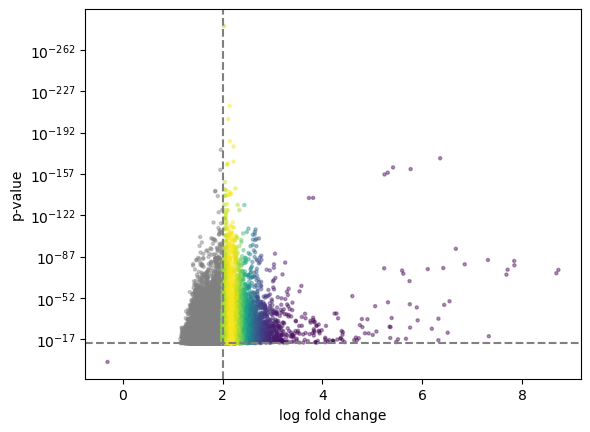

In [13]:
plot_volcano(fold_change_data_adaptive, pval_threshold=1e-14, fold_change_threshold=2)

In [14]:
all_adaptive_cm[['run'] + list(selected_clones)].to_csv('data/sign_clone_matrix_fold_change_adaptive.csv')

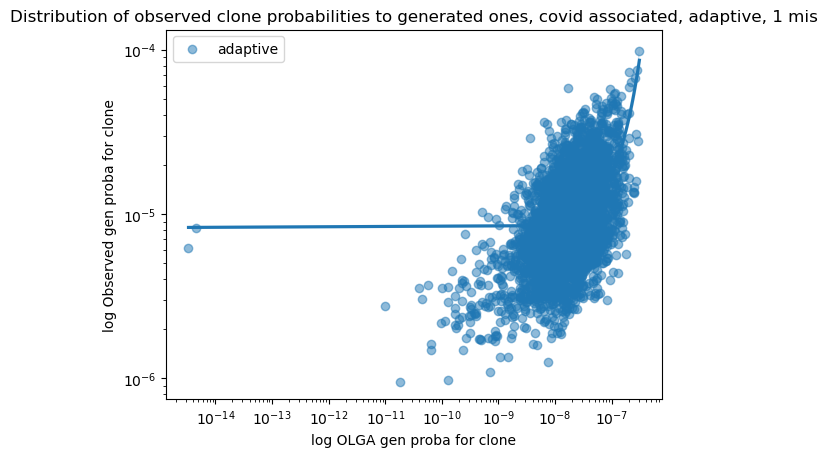

In [15]:
probas_adaptive = plot_generated_to_real_distribution(pgen_paths=['data/covid_adaptive_pgen.csv'], 
                                    cm_paths=['data/sign_clone_matrix_fold_change.csv'], 
                                    desc='covid associated, adaptive, 1 mis', 
                                    run_to_number_of_clones_path='data/run_to_number_of_clones_adaptive.csv', 
                                    labels=['adaptive'],
                                    make_bool_features=False)['adaptive']

In [16]:
vdjdb = pd.read_csv('data/vdjdb.txt', sep='\t')

In [53]:
res_adaptive = seqs2hamming(selected_clones, threshold=1, viz_method='drl')

In [54]:
res_adaptive

,cdr3,cluster,x,y,cluster_size,x_mean,y_mean
0,CASSLGQGNSPLHF,0,22.852001,-128.773239,1888,16.440658,-42.236717
1,CASSLGQNNSPLHF,0,23.463251,-129.474945,1888,16.440658,-42.236717
2,CASSLGQYNSPLHF,0,24.668873,-129.111115,1888,16.440658,-42.236717
3,CASSLGQDNSPLHF,0,23.061153,-128.689590,1888,16.440658,-42.236717
4,CASSLGGGNSPLHF,0,84.017303,-19.837004,1888,16.440658,-42.236717
...,...,...,...,...,...,...,...
7577,CASSYSRGRGETQYF,311,437.467804,154.981461,1,437.467804,154.981461
7578,CASSLAGQGTGYTF,312,-501.733154,31.416704,1,-501.733154,31.416704
7579,CASSYSGTFSYEQYF,313,-407.877228,274.756134,1,-407.877228,274.756134
7580,CASSLGQRFYGYTF,314,354.607452,-371.754456,1,354.607452,-371.754456


In [19]:
adaptive_cluster_to_epi = {}
for cluster_index in range(res_adaptive.cluster.max() + 1):
    adaptive_cluster_to_epi[cluster_index] = check_significant_epitopes_for_cluster(vdjdb, res_adaptive, cluster_index, dist=1, gene='TRB')

# Making FMBA based classifier

In [20]:
fmba_not_nan_hla = pd.read_csv('data/desc_fmba_not_nan_hla.csv')

In [21]:
fmba_not_nan_hla = fmba_not_nan_hla[fmba_not_nan_hla.COVID_status != 'unknown']

In [22]:
good_fmba_samples = fmba_not_nan_hla.run

In [23]:
good_fmba_samples

0        020000010808_S3_L001.clonotypes.TRB.txt
1       020000110808_S14_L001.clonotypes.TRB.txt
2       020000190808_S27_L001.clonotypes.TRB.txt
3      020000200808_S181_L002.clonotypes.TRB.txt
4       020000280808_S59_L001.clonotypes.TRB.txt
                         ...                    
951    780008510808_S152_L002.clonotypes.TRB.txt
952    780008550808_S150_L002.clonotypes.TRB.txt
953    910000140808_S123_L002.clonotypes.TRB.txt
954    910000320808_S121_L002.clonotypes.TRB.txt
955    910003810808_S120_L002.clonotypes.TRB.txt
Name: run, Length: 956, dtype: object

In [24]:
stand_um_joint['platform'] = stand_um_joint.run.apply(lambda x: 'fmba' if 'TRB' in x else 'adaptive')

In [25]:
stand_um_joint['platform'].value_counts()

adaptive    2200
fmba         956
Name: platform, dtype: int64

In [26]:
data_fmba = prepare_data(run_to_number_of_clones_path = 'data/run_to_number_of_clones_joint.csv',
                 desc_path='data/standardized_usage_matrix_joint.csv',
                 clonotype_matrix_path='data/sign_clone_matrix_joint_fmba_based.csv',
                 hla_keys_path=None,
                 make_freq=True,
                 use_hla_clones=False,
                 use_hla_bool=False,
                 make_all_features_bool=True,
                 use_standardization=True,
                 raw_target_column='covid',
                 raw_target_clumn_success_label='covid',
                 final_target_column='covid',
                 metadata_columns=[])
fmba_good_beta_biomarkers_data = [x for x in pd.read_csv('data/sign_clone_matrix_joint_fmba_based.csv').columns if x.startswith('CAS')]
data_fmba = data_fmba[fmba_good_beta_biomarkers_data + ['covid']]
data_fmba['folder'] = stand_um_joint['project']
data_fmba['platform'] = stand_um_joint['platform']
data_fmba['run'] = stand_um_joint['run']

In [27]:
data_fmba = data_fmba[(data_fmba.run.isin(good_fmba_samples)) | (data_fmba.platform == 'adaptive')].drop(columns=['run', 'platform'])

In [28]:
data_fmba

,CASARGYEQYF,CASDRGYEQYF,CASGLGGNQPQHF,CASGLGGSYEQYF,CASGLSGGNQPQHF,CASKRGYEQYF,CASMRGYEQYF,CASNLGGSYEQYF,CASRGGPYEQYF,CASRQGYEQYF,...,CASSYGQGYEQYF,CASSYGSYEQYF,CASSYGTGSYEQYF,CASSYGTTYEQYF,CASSYGYEQYF,CASSYPGQGYEQYF,CASSYSYEQYF,CASWRGYEQYF,covid,folder
0,-0.714184,-0.671564,-1.080516,-0.937013,23.962096,-0.741417,-0.683655,-0.821068,-0.911429,-1.138937,...,1.260564,1.087191,-1.282440,-0.891705,-1.825636,-0.865385,-0.256705,-0.651351,1,NovaSeq5
1,-0.714184,-0.671564,-1.080516,-0.937013,1.586380,-0.741417,-0.683655,-0.821068,-0.911429,-0.084055,...,1.259589,-1.445555,0.994763,4.075972,0.415982,-0.865385,2.359621,-0.651351,1,NovaSeq5
2,-0.714184,-0.671564,0.280576,-0.937013,-0.446967,-0.741417,-0.683655,-0.821068,-0.911429,0.117635,...,0.178215,0.062395,1.430157,0.587665,-0.223511,0.995739,0.473972,-0.651351,0,NovaSeq5
3,3.210103,3.142514,-1.080516,-0.937013,5.180735,3.033313,3.269616,-0.821068,-0.911429,-1.138937,...,0.435796,-1.445555,7.121058,-0.891705,1.896845,-0.865385,-1.752605,3.386953,1,NovaSeq5
4,-0.714184,-0.671564,-1.080516,-0.937013,-0.446967,-0.741417,-0.683655,-0.821068,-0.911429,-1.138937,...,-1.414420,2.883662,-1.282440,-0.891705,1.240755,-0.865385,-0.047979,-0.651351,1,NovaSeq5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3150,0.186723,0.495911,0.129502,0.334327,-0.231640,-0.019273,0.072646,0.049162,0.537568,-0.133549,...,0.567785,0.163134,0.405618,0.686495,0.453238,0.458254,0.226833,0.121217,0,KECK
3151,0.918161,0.716626,-0.093927,0.142767,-0.154355,0.436184,0.549646,-0.348039,0.182498,0.530913,...,-0.356199,0.102916,0.574553,0.716779,0.303417,0.933332,0.345512,0.608478,0,KECK
3152,0.750270,0.277320,-0.424875,-0.420361,-0.213619,0.197678,0.299858,-0.255233,0.309885,0.555884,...,-0.033504,-0.355981,-0.237109,-0.321613,-0.024894,0.031122,-0.122334,0.353317,0,KECK
3153,0.296762,0.310990,0.432475,0.744366,0.588581,0.092084,0.043783,1.355181,0.946835,0.042975,...,0.560228,0.488564,1.500935,0.246773,0.092280,-0.069683,0.874770,0.091733,0,KECK


In [29]:
X_train_fmba, y_train_fmba, X_test_fmba, y_test_fmba = split_data_by_batch(data=data_fmba, 
                                                       test_batches=[x for x in stand_um_joint.project.unique() if 'Nova' not in x], 
                                                       y_column='covid', 
                                                       batch_column='folder')

In [30]:
fmba_clf = SVC(C=5, kernel='rbf', probability=True, random_state=42).fit(X_train_fmba, y_train_fmba)

In [31]:
y_pred_fmba = fmba_clf.predict(X_test_fmba)

In [32]:
metrics_fmba = pd.DataFrame({'f1': [round(f1_score(y_test_fmba, y_pred_fmba), 2)], 
              'precision': [round(precision_score(y_test_fmba, y_pred_fmba), 2)], 
              'recall': [round(recall_score(y_test_fmba, y_pred_fmba), 2)]})

In [75]:
fmba_cm = pd.read_csv('data/sign_clone_matrix_joint_fmba_based.csv').drop(columns=['Unnamed: 0'])
fmba_clones = fmba_cm.drop(columns=['run']).columns
res_fmba = seqs2hamming(fmba_clones, threshold=1, viz_method='drl')
metaclone_fmba_cm = make_metaclone_cm(fmba_cm, res_fmba)
metaclone_fmba_cm.to_csv('data/clone_matrix_covid_fmba_and_adaptive_metaclone.csv')

In [77]:
data_fmba_meta = prepare_data(run_to_number_of_clones_path = 'data/run_to_number_of_clones_joint.csv',
                 desc_path='data/standardized_usage_matrix_joint.csv',
                 clonotype_matrix_path='data/clone_matrix_covid_fmba_and_adaptive_metaclone.csv',
                 hla_keys_path=None,
                 make_freq=True,
                 use_hla_clones=False,
                 use_hla_bool=False,
                 make_all_features_bool=True,
                 use_standardization=True,
                 raw_target_column='covid',
                 raw_target_clumn_success_label='covid',
                 final_target_column='covid',
                 metadata_columns=[])
data_fmba_meta['folder'] = stand_um_joint['project']
data_fmba_meta['platform'] = stand_um_joint['platform']
data_fmba_meta['run'] = stand_um_joint['run']

In [78]:
X_train_fmba_m, y_train_fmba_m, X_test_fmba_m, y_test_fmba_m = split_data_by_batch(data=data_fmba_meta.drop(columns=['run', 'platform']), 
                                                       test_batches=[x for x in stand_um_joint.project.unique() if 'Nova' not in x], 
                                                       y_column='covid', 
                                                       batch_column='folder')

In [80]:
fmba_clf_m = SVC(C=5, kernel='rbf', probability=True, random_state=42).fit(X_train_fmba_m, y_train_fmba_m)
y_pred_fmba_m = fmba_clf_m.predict(X_test_fmba_m)

In [81]:
metrics_fmba_m = pd.DataFrame({'f1': [round(f1_score(y_test_fmba_m, y_pred_fmba_m), 2)], 
              'precision': [round(precision_score(y_test_fmba_m, y_pred_fmba_m), 2)], 
              'recall': [round(recall_score(y_test_fmba_m, y_pred_fmba_m), 2)]})

# Making Adaptive based classifier

In [88]:
data_adaptive = prepare_data(run_to_number_of_clones_path='data/run_to_number_of_clones_joint_50k.csv',
             desc_path='data/standardized_usage_matrix_joint.csv',
             clonotype_matrix_path='data/sign_clone_matrix_fold_change_adaptive.csv',
             hla_keys_path=None,
             make_freq=True,
             use_hla_clones=False,
             use_hla_bool=False,
             use_standardization=True,
             raw_target_column='covid',
             raw_target_clumn_success_label='covid',
             final_target_column='covid',
             metadata_columns=[])

data_adaptive['folder'] = stand_um_joint['project']
data_adaptive['platform'] = stand_um_joint['platform']
data_adaptive['run'] = stand_um_joint['run']

In [89]:
data_adaptive = data_adaptive[(data_adaptive.run.isin(good_fmba_samples)) | (data_adaptive.platform == 'adaptive')].drop(columns=['run', 'platform'])

In [90]:
X_train_adaptive, y_train_adaptive, X_test_adaptive, y_test_adaptive = split_data_by_batch(data=data_adaptive, 
                                                                           test_batches=[x for x in stand_um_joint.project.unique() if 'Nova' in x], 
                                                                           y_column='covid', 
                                                                           batch_column='folder')

In [91]:
adaptive_clf = SVC(C=5, kernel='rbf', probability=True, random_state=42).fit(X_train_adaptive, y_train_adaptive)

In [92]:
y_pred_adaptive = adaptive_clf.predict(X_test_adaptive)

In [93]:
metrics_adaptive = pd.DataFrame({'f1': [round(f1_score(y_test_adaptive, y_pred_adaptive), 2)], 
              'precision': [round(precision_score(y_test_adaptive, y_pred_adaptive), 2)], 
              'recall': [round(recall_score(y_test_adaptive, y_pred_adaptive), 2)]})

In [94]:
adaptive_cm = pd.read_csv('data/sign_clone_matrix_fold_change_adaptive.csv').drop(columns=['Unnamed: 0'])
adaptive_clones = adaptive_cm.drop(columns=['run']).columns
res_adaptive = seqs2hamming(adaptive_clones, threshold=1, viz_method='drl')
metaclone_adaptive_cm = make_metaclone_cm(adaptive_cm, res_adaptive)
metaclone_adaptive_cm.to_csv('data/clone_matrix_covid_fmba_and_adaptive_metaclone_adaptive_based.csv')

data_adaptive_meta = prepare_data(run_to_number_of_clones_path = 'data/run_to_number_of_clones_joint_50k.csv',
                 desc_path='data/standardized_usage_matrix_joint.csv',
                 clonotype_matrix_path='data/clone_matrix_covid_fmba_and_adaptive_metaclone_adaptive_based.csv',
                 hla_keys_path=None,
                 make_freq=True,
                 use_hla_clones=False,
                 use_hla_bool=False,
                 use_standardization=True,
                 raw_target_column='covid',
                 raw_target_clumn_success_label='covid',
                 final_target_column='covid',
                 metadata_columns=[])
data_adaptive_meta['folder'] = stand_um_joint['project']
data_adaptive_meta['platform'] = stand_um_joint['platform']
data_adaptive_meta['run'] = stand_um_joint['run']

X_train_adaptive_m, y_train_adaptive_m, X_test_adaptive_m, y_test_adaptive_m = split_data_by_batch(
                                                       data=data_adaptive_meta.drop(columns=['run', 'platform']), 
                                                       test_batches=[x for x in stand_um_joint.project.unique() if 'Nova' in x], 
                                                       y_column='covid', 
                                                       batch_column='folder')

adaptive_clf_m = SVC(C=5, kernel='rbf', probability=True, random_state=42).fit(X_train_adaptive_m, y_train_adaptive_m)
y_pred_adaptive_m = adaptive_clf_m.predict(X_test_adaptive_m)

metrics_adaptive_m = pd.DataFrame({'f1': [round(f1_score(y_test_adaptive_m, y_pred_adaptive_m), 2)], 
              'precision': [round(precision_score(y_test_adaptive_m, y_pred_adaptive_m), 2)], 
              'recall': [round(recall_score(y_test_adaptive_m, y_pred_adaptive_m), 2)]})

# Making joint df for metrics

In [95]:
y_test_data = {
    'fmba->adaptive': y_test_fmba,
    'adaptive->fmba': y_test_adaptive,
    'fmba_meta->adaptive': y_test_fmba_m,
    'adaptive_meta->fmba': y_test_adaptive_m,
} 
all_clfs = {
    'fmba->adaptive': fmba_clf,
    'adaptive->fmba': adaptive_clf,
    'fmba_meta->adaptive': fmba_clf_m,
    'adaptive_meta->fmba': adaptive_clf_m
} 
X_test_data = {
    'fmba->adaptive': X_test_fmba,
    'adaptive->fmba': X_test_adaptive,
    'fmba_meta->adaptive': X_test_fmba_m,
    'adaptive_meta->fmba': X_test_adaptive_m
} 

In [96]:
metrics = pd.concat([metrics_fmba, metrics_adaptive, metrics_fmba_m, metrics_adaptive_m])
metrics.index = ['fmba->adaptive', 'adaptive->fmba', 'fmba_meta->adaptive', 'adaptive_meta->fmba']

In [97]:
metrics

,f1,precision,recall
fmba->adaptive,0.78,0.66,0.95
adaptive->fmba,0.82,0.69,1.00
fmba_meta->adaptive,0.78,0.65,0.98
adaptive_meta->fmba,0.82,0.69,1.00


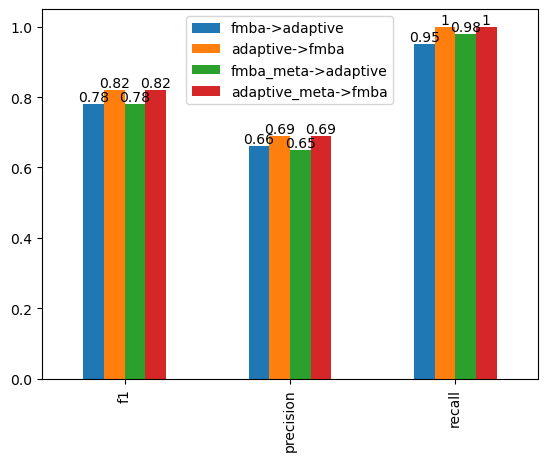

In [98]:
fig, ax = plt.subplots()
metrics.T.plot.bar(ax=ax)
for c in ax.containers:
    ax.bar_label(c, label_type='edge')

# Making joint clustering results

In [43]:
covid_clones_fmba_beta = pd.read_csv('data/significant_clone_matrix_fisher_fmba_TRB_top_500k_wo_leaks.csv').drop(columns=['Unnamed: 0']).columns[1:]

In [55]:
res_joint = seqs2hamming(list(selected_clones) + list(covid_clones_fmba_beta), threshold=1, viz_method='drl')

In [56]:
res_joint['platform'] = res_joint.cdr3.apply(lambda x: 'joint' if x in covid_clones_fmba_beta and x in selected_clones else ('fmba' if x in covid_clones_fmba_beta else 'adaptive'))

In [57]:
res_joint

,cdr3,cluster,x,y,cluster_size,x_mean,y_mean,platform
0,CASSLGQGNSPLHF,0,-56.394955,37.812477,1888,-17.008299,-15.737382,adaptive
1,CASSLGQNNSPLHF,0,-58.696907,41.473957,1888,-17.008299,-15.737382,adaptive
2,CASSLGQYNSPLHF,0,-58.425266,41.790291,1888,-17.008299,-15.737382,adaptive
3,CASSLGQDNSPLHF,0,-59.338898,42.104282,1888,-17.008299,-15.737382,adaptive
4,CASSLGGGNSPLHF,0,-63.751839,-84.627953,1888,-17.008299,-15.737382,adaptive
...,...,...,...,...,...,...,...,...
8075,CSARTSYEQYF,362,-377.045990,138.001999,5,-376.996466,138.369528,fmba
8076,CSASDRGYEQYF,363,-372.375580,336.565186,1,-372.375580,336.565186,fmba
8077,CSASDSYEQYF,364,507.186493,41.229507,1,507.186493,41.229507,fmba
8078,CSASGGGYEQYF,365,-437.666809,262.679901,1,-437.666809,262.679901,fmba


In [47]:
joint_cluster_to_epi = {}
for cluster_index in range(res_joint.cluster.max() + 1):
    joint_cluster_to_epi[cluster_index] = check_significant_epitopes_for_cluster(vdjdb, res_joint, cluster_index, dist=1, gene='TRB')

LPDDFTGCV


(-900.0, 900.0)

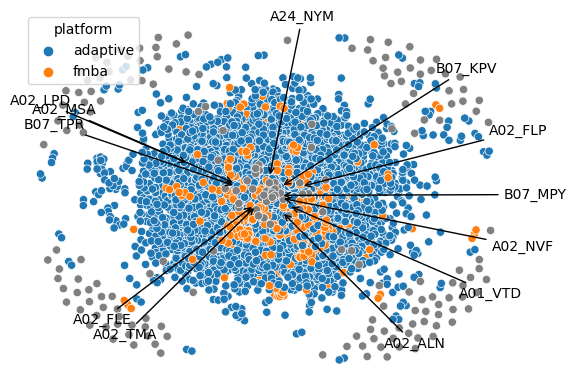

In [48]:
fig, ax = plt.subplots()
plot_clonotype_clustering_with_epitope_labeling(res_joint, 
                                                joint_cluster_to_epi, 
                                                vdjdb, 
                                                gene='TRB',
                                                color_by='platform',
                                                cluster_size_threshold=0, 
                                                dist_to_center=850, 
                                                center_diff_threshold=75,
                                                ax=ax)
ax.set_xlim(-900, 900)
ax.set_ylim(-900, 900)


# Plotting Fig 5

[[2.02983484e+000 2.00450801e+000 2.07049518e+000 ... 2.17653379e+000
  2.00987475e+000 2.28540222e+000]
 [3.97225335e-283 1.04285276e-155 8.89196164e-144 ... 1.75862887e-022
  7.58600986e-021 8.77455510e-038]]
FLEGETLPT
NYMPYFFTL


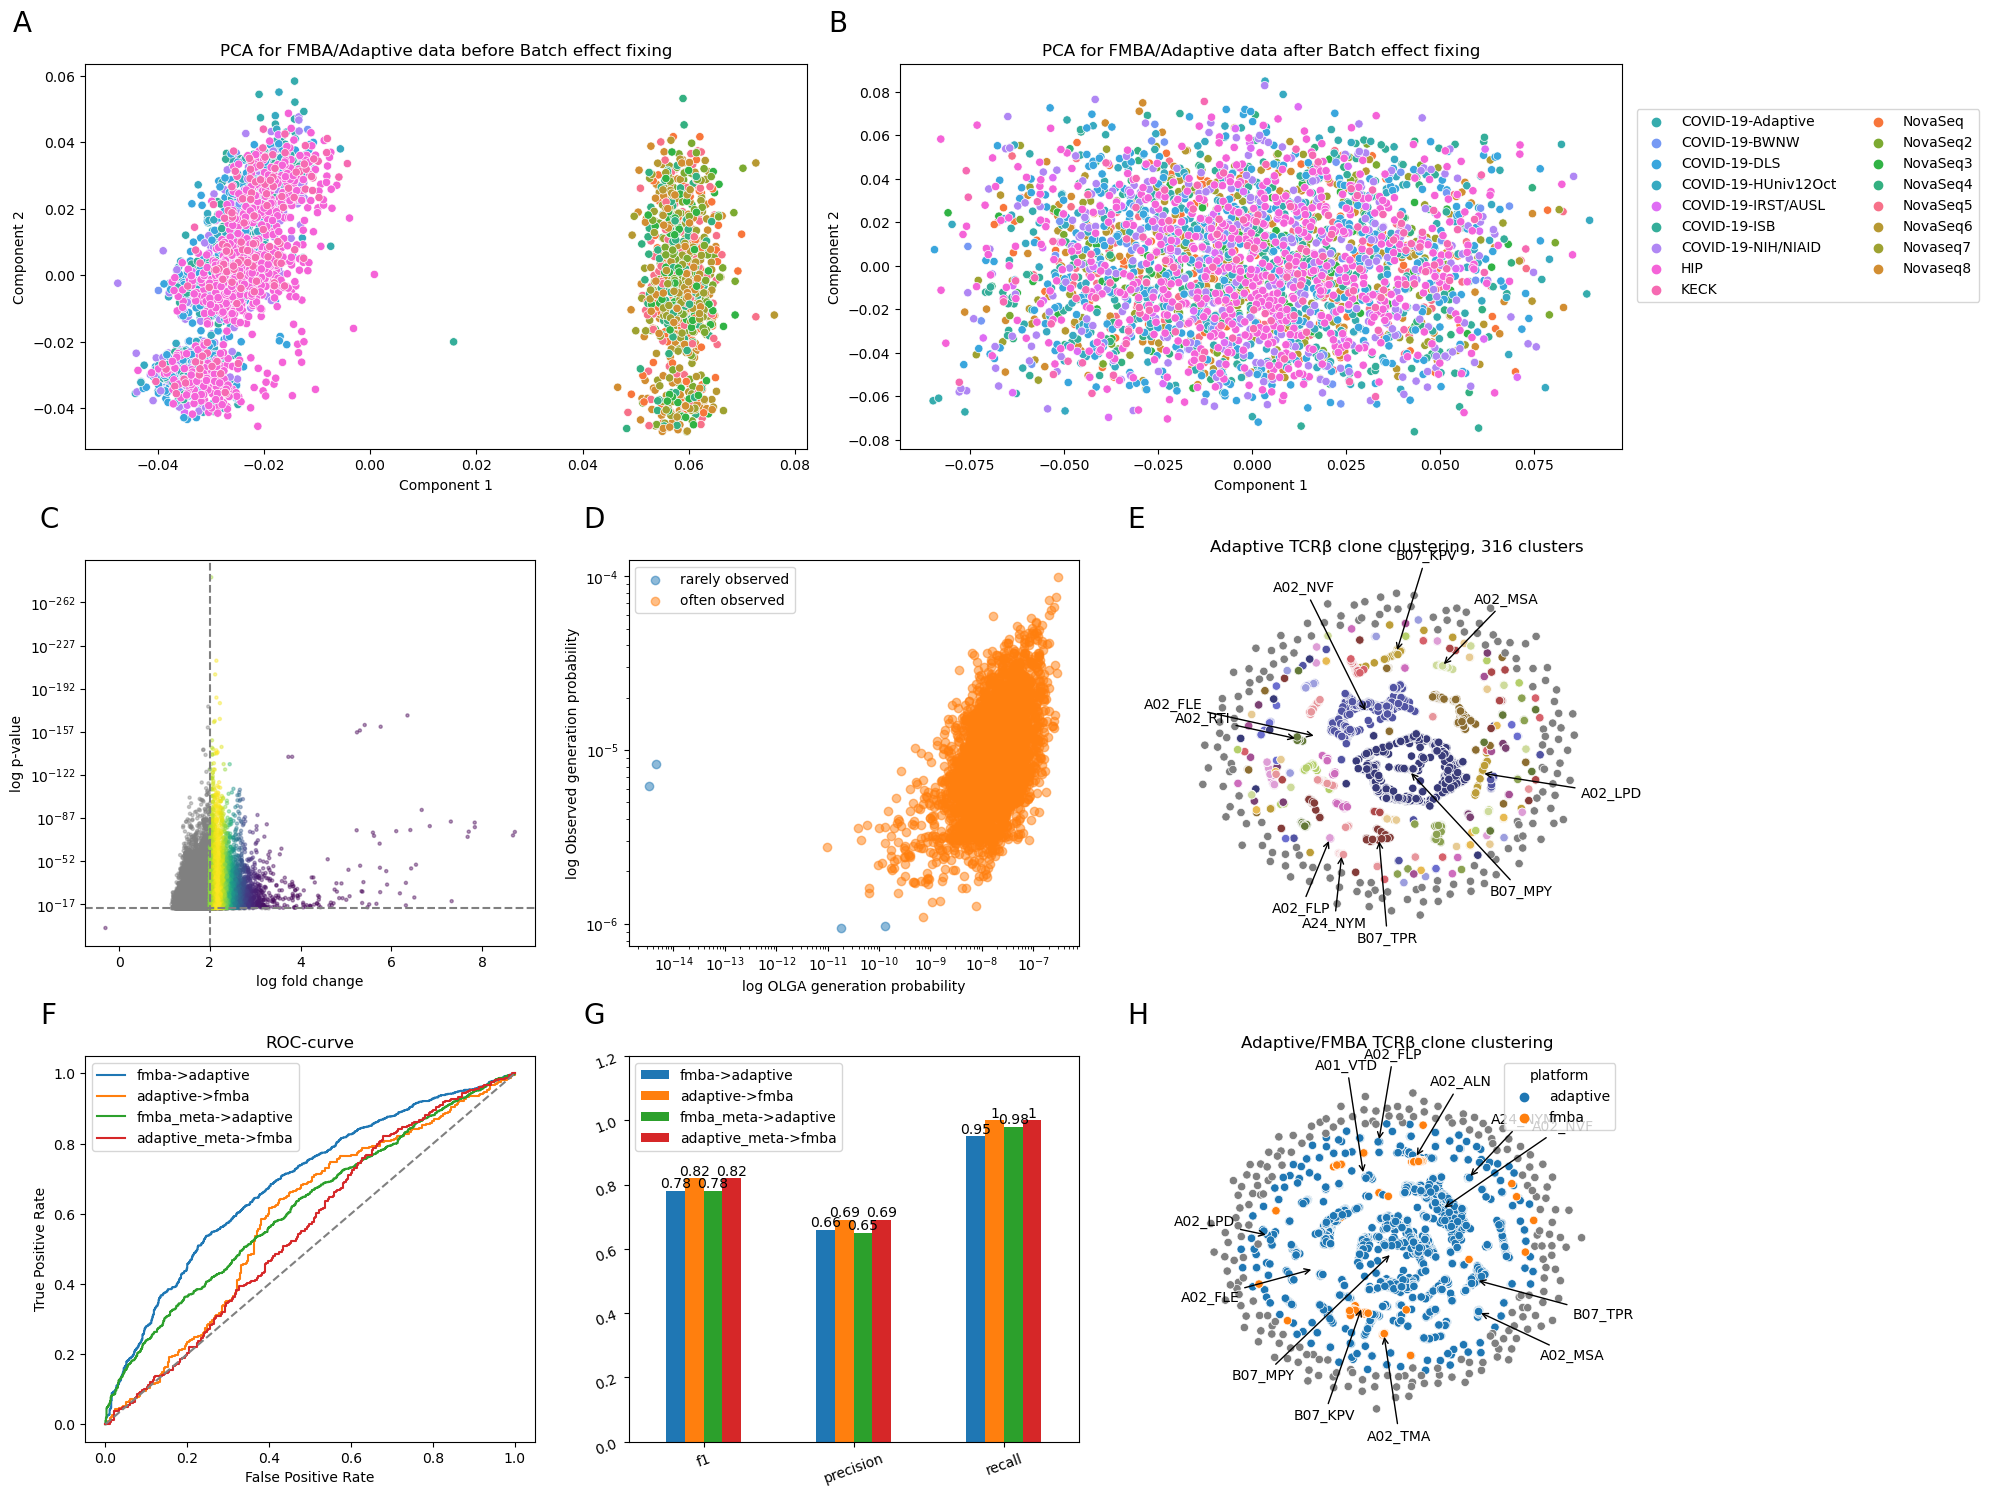

In [99]:
fig = plt.figure(figsize=(20, 15))
gs = GridSpec(nrows=3, 
              ncols=6)
font_size=20
delta_x=-0.1
delta_y=1.14

########################################################
ax0 = fig.add_subplot(gs[0, :3])

plot_usage_matrix_pca(norm_um_joint, method=PCA, target='project', ax=ax0)

ax0.legend()
ax0.set_title('PCA for FMBA/Adaptive data before Batch effect fixing')
ax0.text(delta_x, delta_y, 'A',
     horizontalalignment='left',
     verticalalignment='top',
    transform=ax0.transAxes,
        size=font_size)
ax0.legend([],[], frameon=False)

########################################################
ax1 = fig.add_subplot(gs[0, 3:])

plot_usage_matrix_pca(stand_um_joint, method=PCA, target='project', ax=ax1)

ax1.legend()
ax1.set_title('PCA for FMBA/Adaptive data after Batch effect fixing')
ax1.text(delta_x, delta_y, 'B',
     horizontalalignment='left',
     verticalalignment='top',
    transform=ax1.transAxes,
        size=font_size)
handles, labels = ax1.get_legend_handles_labels()
pairs = [(x, y) for x, y in zip(handles, labels)]
pairs.sort(key=lambda x: x[1])

leg = ax1.legend([x[0] for x in pairs], [x[1] for x in pairs], ncol=2, bbox_to_anchor=(1.01, 0.9)) 

# sns.move_legend(ax1, "upper right", bbox_to_anchor=(1.15, 1.1))
########################################################

ax3 = fig.add_subplot(gs[1, :2])
plot_volcano(fold_change_data_adaptive, pval_threshold=1e-14, fold_change_threshold=2, ax=ax3)
ax3.text(delta_x, delta_y, 'C',
     horizontalalignment='left',
     verticalalignment='top',
    transform=ax3.transAxes,
        size=font_size)
ax3.set_ylabel('log p-value')

########################################################

ax4 = fig.add_subplot(gs[1, 2:4])
plot_olga_cleanup_data(probas_adaptive, observed_threshold=1e-6, gen_threshold=1e-12, ax=ax4)
ax4.text(delta_x, delta_y, 'D',
     horizontalalignment='left',
     verticalalignment='top',
    transform=ax4.transAxes,
        size=font_size)

########################################################

ax5 = fig.add_subplot(gs[1, 4:])


plot_clonotype_clustering_with_epitope_labeling(res_adaptive, 
                                                adaptive_cluster_to_epi, 
                                                vdjdb, 
                                                gene='TRB', 
                                                cluster_size_threshold=0, 
                                                dist_to_center=550, 
                                                center_diff_threshold=75,
                                                ax=ax5)
ax5.text(delta_x, delta_y, 'E',
     horizontalalignment='left',
     verticalalignment='top',
    transform=ax5.transAxes,
        size=font_size)
ax5.set_title(f'Adaptive TCRβ clone clustering, {res_adaptive.cluster.max() + 1} clusters')
ax5.axis('off')
ax5.set_xlim(-650, 650)
ax5.set_ylim(-650, 650)
ax5.legend([],[], frameon=False)

########################################################

ax6 = fig.add_subplot(gs[2, :2])

for key in ['fmba->adaptive', 'adaptive->fmba', 'fmba_meta->adaptive', 'adaptive_meta->fmba']:
    fpr, tpr, _ = roc_curve(y_test_data[key], all_clfs[key].predict_proba(X_test_data[key])[::,1])
    ax6.plot(fpr,tpr, label=key)

ax6.set_ylabel('True Positive Rate')
ax6.set_xlabel('False Positive Rate')
ax6.plot([0, 1], [0, 1], linestyle='dashed', color='grey')
ax6.legend()
ax6.set_title('ROC-curve')
ax6.text(delta_x, delta_y, 'F',
     horizontalalignment='left',
     verticalalignment='top',
    transform=ax6.transAxes,
        size=font_size)


########################################################

ax2 = fig.add_subplot(gs[2, 2:4])

metrics.T.plot.bar(ax=ax2)
for c in ax2.containers:
    ax2.bar_label(c, label_type='edge')
ax2.set_ylim(0, 1.2)
ax2.tick_params(labelrotation=20)
ax2.text(delta_x, delta_y, 'G',
     horizontalalignment='left',
     verticalalignment='top',
    transform=ax2.transAxes,
        size=font_size)
########################################################

ax5 = fig.add_subplot(gs[2, 4:])
plot_clonotype_clustering_with_epitope_labeling(res_joint, 
                                                joint_cluster_to_epi, 
                                                vdjdb, 
                                                gene='TRB',
                                                color_by='platform',
                                                cluster_size_threshold=0, 
                                                dist_to_center=600, 
                                                center_diff_threshold=75,
                                                ax=ax5)
ax5.set_xlim(-700, 700)
ax5.set_ylim(-700, 700)
ax5.text(delta_x, delta_y, 'H',
     horizontalalignment='left',
     verticalalignment='top',
    transform=ax5.transAxes,
        size=font_size)
ax5.axis('off')
ax5.set_title('Adaptive/FMBA TCRβ clone clustering')

########################################################

plt.tight_layout()
plt.savefig("figures/fig5.svg")
plt.savefig("figures/fig5.pdf")
plt.savefig("figures/fig5.png")
plt.show()
